In [242]:
import stdpopsim
import numpy as np
import os
import tskit

In [243]:
## CONSTANTS
seed = 11379
num_reps = 50
sp_name = "HomSap"
chrom = "chr13"
model_name ="OutOfAfrica_3G09"
sample_size=10
engine = stdpopsim.get_engine("msprime")
rng = np.random.default_rng(seed)
seed_array = rng.integers(1,2**31,num_reps)
sims_path = f"data/sims/{sp_name}/{chrom}/{model_name}/"

In [244]:
os.makedirs(sims_path, exist_ok=True)

In [245]:
species = stdpopsim.get_species(sp_name)
model = species.get_demographic_model(model_name)
contig = species.get_contig(chrom, mutation_rate=model.mutation_rate)
samples = {pop.name: sample_size for pop in model.populations}

In [246]:
ts_paths = []
num_trees_list = []
for seed in seed_array:
    spath = f"{sims_path}sim_{seed}.ts"
    ts_paths.append(spath)
    if os.path.exists(spath):
        ts = tskit.load(spath)
        num_trees_list.append(ts.num_trees)
    else:
        ts = engine.simulate(model, contig, samples, seed=seed)
        ts.dump(spath)

In [247]:
norm_factor = (model.model.debug().mean_coalescence_time({"YRI":2})*4)

In [248]:
ts=tskit.load("data/sims/HomSap/chr13/OutOfAfrica_3G09/sim_1057502661.ts")

In [249]:
tree = next(ts.trees())

In [250]:
ts.node(8).is_sample()

1

In [251]:
import torch
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
import torch.nn.functional as F


In [252]:
def convert_tree(tree, ts):
    dtree = tree.as_dict_of_dicts()
    edge_index = []
    node_map = {node:i for i, node in enumerate(tree.nodes())}
    for p, dic in dtree.items():
        for c, dic2 in dic.items():
            edge_index.append([node_map[p],node_map[c]])
    assert len(edge_index) == tree.num_edges
    node_features = []
    for i, node in enumerate(tree.nodes()):
        node_features.append([ts.node(node).time, ts.node(node).is_sample()])
    assert len(node_features) == len(tree.preorder())
    return torch.IntTensor(edge_index).T, torch.FloatTensor(node_features)

In [253]:

class TreeSequenceDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None, seeds=None, num_trees_list=None, norm_factor=1):
        self.seeds = seeds
        self.num_trees_list = num_trees_list
        self.norm_factor = norm_factor
        super().__init__(root, transform, pre_transform, pre_filter)

    @property
    def raw_file_names(self):
        return [f'data/sims/HomSap/chr13/OutOfAfrica_3G09/sim_{s}.ts' for s in self.seeds]

    @property
    def processed_file_names(self):
        file_list = []
        total = 0
        for x, (_, max_num_trees) in enumerate(zip(self.seeds, self.num_trees_list)):
            n = 0
            for _ in range(max_num_trees):
                if n >= max_num_trees:
                    break 
                file_list.append(f'tree_{total}.pt')
                total += 1
                n += 1
        return file_list

    def download(self):
        pass

    def process(self):
        total = 0
        for x, (raw_file_name, seed) in enumerate(zip(self.raw_file_names, self.seeds)):
            ts = tskit.load(raw_file_name)
            tree_breaks = [x for x in ts.breakpoints()]
            div = ts.diversity(windows=tree_breaks, mode="branch")
            for i, tree in enumerate(ts.trees()):
                if i >= self.num_trees_list[x]:
                    break
                print(f"Processing tree {total} from ts {seed}")
                edge_index, node_features = convert_tree(tree, ts)
                #print(edge_index, edge_features)
                data = Data(x=node_features, edge_index=edge_index,y=div[i]/norm_factor)
                torch.save(data, os.path.join(self.processed_dir, f'tree_{total}.pt'))
                total += 1
    def len(self):
        return len(self.processed_file_names)
    def get(self, idx):
        data = torch.load(os.path.join(self.processed_dir, f'tree_{idx}.pt'))
        return data

In [254]:
dataset = TreeSequenceDataset("data/",seeds=seed_array[:1], num_trees_list=[10_000], norm_factor=norm_factor)

In [255]:
all_y = []
for data in dataset:
    all_y.append(data.y)

In [256]:
np.array(all_y).mean()

0.4681129149424512

In [257]:
np.array(all_y).std()

0.21319604964312489

In [258]:
loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [259]:
i = 0
for batch in loader:
    i+=1
    if i >1:
        break

In [260]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv, pool, SAGEConv

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = SAGEConv(dataset.num_features, 48)
        self.conv2 = SAGEConv(48, 12)
        self.conv3 = SAGEConv(12, 4, normalize=False)
        self.outp = Linear(4, 1)

    def forward(self, data):
        batch, x, edge_index = data.batch, data.x, data.edge_index
        edge_index = edge_index.type('torch.LongTensor')
        #x = x.type('torch.LongTensor')
        #image.pngprint(x.type(), edge_index.type())
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = self.conv2(h, edge_index)
        h = F.relu(h)
        h = self.conv3(h, edge_index)
        h = F.relu(h) # Final GNN embedding space.
        
        # Apply a final (linear) regression.
        out = self.outp(h)
        pooled_out = F.relu(pool.global_add_pool(out, batch))
        return pooled_out

model = GCN()
print(model)

GCN(
  (conv1): SAGEConv(2, 48, aggr=mean)
  (conv2): SAGEConv(48, 12, aggr=mean)
  (conv3): SAGEConv(12, 4, aggr=mean)
  (outp): Linear(in_features=4, out_features=1, bias=True)
)


In [261]:
from torch.utils.data import random_split


train_set, valid_set, test_set = random_split(dataset,[4000, 3000, 3000])

trainloader = DataLoader(train_set, batch_size=512, shuffle=True)
validloader = DataLoader(valid_set, batch_size=512, shuffle=True)
testloader = DataLoader(test_set, batch_size=512, shuffle=True)

In [262]:
model = GCN()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
num_epochs=10
device = torch.device("cpu")
criterion = torch.nn.L1Loss()

for epoch in range(num_epochs):
    epoch_loss = 0
    model.train()
    num_batches = 0
    for batch in trainloader:
        num_batches+=1
        batch.to(device)
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output,batch.y.unsqueeze(1).type(torch.FloatTensor))
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
    
    train_avg_loss = epoch_loss / num_batches
    val_loss = 0
    model.eval()
    num_batches = 0
    for batch in validloader:
        num_batches+=1
        batch.to(device)
        output = model(batch)
        loss = criterion(output,batch.y.unsqueeze(1).type(torch.FloatTensor))
        val_loss += loss.item()
    val_avg_loss = val_loss/num_batches
    
    
    print(f"Epochs: {epoch} | epoch avg. loss: {train_avg_loss:.2f} | validation avg. loss: {val_avg_loss:.2f}")

Epochs: 0 | epoch avg. loss: 2869.33 | validation avg. loss: 0.47
Epochs: 1 | epoch avg. loss: 0.47 | validation avg. loss: 0.47
Epochs: 2 | epoch avg. loss: 0.47 | validation avg. loss: 0.47
Epochs: 3 | epoch avg. loss: 0.47 | validation avg. loss: 0.47
Epochs: 4 | epoch avg. loss: 0.47 | validation avg. loss: 0.47
Epochs: 5 | epoch avg. loss: 0.47 | validation avg. loss: 0.47
Epochs: 6 | epoch avg. loss: 0.47 | validation avg. loss: 0.47
Epochs: 7 | epoch avg. loss: 0.47 | validation avg. loss: 0.47
Epochs: 8 | epoch avg. loss: 0.47 | validation avg. loss: 0.47
Epochs: 9 | epoch avg. loss: 0.47 | validation avg. loss: 0.47


In [263]:
model.eval()

GCN(
  (conv1): SAGEConv(2, 48, aggr=mean)
  (conv2): SAGEConv(48, 12, aggr=mean)
  (conv3): SAGEConv(12, 4, aggr=mean)
  (outp): Linear(in_features=4, out_features=1, bias=True)
)

In [264]:
batch.num_graphs

440

In [265]:
model.eval()
predictions = []
real = []

for batch in testloader:
    
    output = model(batch.to(device))
    predictions.append(output.detach().cpu().numpy())
    real.append(batch.y.detach().cpu().numpy())

predictions = np.concatenate(predictions)
real = np.concatenate(real)

Text(0.5, 0, 'Observed diversity')

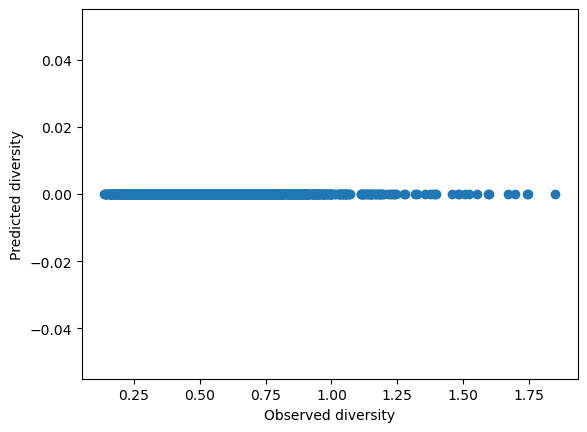

In [266]:
import matplotlib.pyplot as plt


plt.scatter(real,predictions)
plt.ylabel('Predicted diversity')
plt.xlabel('Observed diversity')